In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.linalg import pinv, norm
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt

from HW1 import *

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# 圖片來源種類

In [3]:
source='venus' # 'star'

# read LightSource.txt
讀取光源

In [4]:
with open("test/{}/LightSource.txt".format(source),'r') as f:
    L = []
    for l in f.readlines():
        l = l.replace('\n','').replace('(','').replace(')','').split(' ')[1].split(',')
        l = [int(i) for i in l]
        L.append(l)

# to array        
L = np.array(L)
# normalize
L = normalize(L)

# read images
讀取影像

In [5]:
img1 = read_bmp('test/{}/pic1.bmp'.format(source))
h = img1.shape[0]
w = img1.shape[1]

In [116]:
# img1 = read_bmp('test/{}/pic1.bmp'.format(source)).reshape(-1)
# img2 = read_bmp('test/{}/pic2.bmp'.format(source)).reshape(-1)
# img3 = read_bmp('test/{}/pic3.bmp'.format(source)).reshape(-1)
# img4 = read_bmp('test/{}/pic4.bmp'.format(source)).reshape(-1)
# img5 = read_bmp('test/{}/pic5.bmp'.format(source)).reshape(-1)
# img6 = read_bmp('test/{}/pic6.bmp'.format(source)).reshape(-1)

In [171]:
# 高斯模糊
img1_blur = cv2.GaussianBlur(read_bmp('test/{}/pic1.bmp'.format(source)),(3, 15), 0).reshape(-1)
img2_blur = cv2.GaussianBlur(read_bmp('test/{}/pic2.bmp'.format(source)),(3, 15), 0).reshape(-1)
img3_blur = cv2.GaussianBlur(read_bmp('test/{}/pic3.bmp'.format(source)),(3, 15), 0).reshape(-1)
img4_blur = cv2.GaussianBlur(read_bmp('test/{}/pic4.bmp'.format(source)),(3, 15), 0).reshape(-1)
img5_blur = cv2.GaussianBlur(read_bmp('test/{}/pic5.bmp'.format(source)),(3, 15), 0).reshape(-1)
img6_blur = cv2.GaussianBlur(read_bmp('test/{}/pic6.bmp'.format(source)),(3, 15), 0).reshape(-1)

# # create a CLAHE object
# clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# cl1 = clahe.apply(img)
# res = np.hstack((img, cl1))

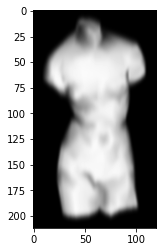

In [173]:
temp = cv2.GaussianBlur(read_bmp('test/{}/pic1.bmp'.format(source)),(3, 15), 0)
plt.imshow(temp, cmap='gray', vmin=0, vmax=255)
plt.show()

In [174]:
I = np.vstack((img1_blur,img2_blur,img3_blur,img4_blur,img5_blur,img6_blur))
I.shape

(6, 25440)

# KdN
利用pesudo-inverse計算KdN

In [175]:
KdN = pinv((L.T@L))@L.T@I
KdN = KdN.T        # 需要再轉置一次，畫出來結果才是對的
N = normalize(KdN) # 正規化

# 影像呈現

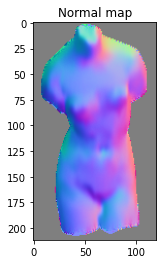

In [176]:
normal_visualization(N)

# Mask
製作mask判斷使用哪個方向向量

In [177]:
N_copy = N.reshape((w,h,3))

# 只挑出要計算的pixel!!
index = {}
c = 0
Mask = np.zeros((w,h))
for x in range(w):
    for y in range(h):
        if (N_copy[x,y] == np.array([0,0,0])).all():
            Mask[x,y] = 0
        else:
            Mask[x,y] = 1
            index[(x,y)] = c
            c += 1

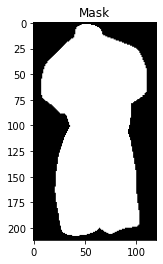

In [178]:
mask_visualization(Mask)

In [179]:
# 只需計算!!!!!!!!!
len(index)

15007

# Surface Reconstruction(新版)

In [180]:
s = len(index)
M = np.zeros((2 * s, s))
V = np.zeros((2 * s, 1))

In [181]:
# 用Mask來判斷向量方向並製作 M & V
i_row_pointer = 0
j_row_pointer = s
for key in index:
    i = key[0]
    j = key[1]
    
    nx = N_copy[i][j][0]
    ny = N_copy[i][j][1]
    nz = N_copy[i][j][2]  
    '''超過圖片範圍就丟棄'''
    if i-1>=0 and j-1>=0 and i+1<w and j+1<h:
        '''填表'''
        if Mask[i,j+1]>0 and Mask[i-1,j]>0:           # 如果東北方向存在
            M[i_row_pointer][index[(i,j+1)]] = 1        # (i,j+1)
            M[j_row_pointer][index[(i-1,j)]] = 1        # (i-1,j)
            M[i_row_pointer][index[(i,j)]]   = -1       # (i,j)
            M[j_row_pointer][index[(i,j)]]   = -1       # (i,j)
            V[i_row_pointer] = -nx/nz if nz!=0 else 0 
            V[j_row_pointer] = -ny/nz if nz!=0 else 0
        elif Mask[i,j-1]>0 and Mask[i-1,j]>0:         # 如果西北方向存在(東不存在)
            M[i_row_pointer][index[(i,j-1)]] = 1        # (i,j-1)
            M[j_row_pointer][index[(i-1,j)]] = 1        # (i-1,j)
            M[i_row_pointer][index[(i,j)]]   = -1       # (i,j)
            M[j_row_pointer][index[(i,j)]]   = -1       # (i,j)
            V[i_row_pointer] =  nx/nz if nz!=0 else 0 
            V[j_row_pointer] = -ny/nz if nz!=0 else 0
        elif Mask[i,j+1]>0 and Mask[i+1,j]>0:         # 如果東南方向存在(北不存在)
            M[i_row_pointer][index[(i,j+1)]] = 1        # (i,j+1)
            M[j_row_pointer][index[(i+1,j)]] = 1        # (i+1,j)
            M[i_row_pointer][index[(i,j)]]   = -1       # (i,j)
            M[j_row_pointer][index[(i,j)]]   = -1       # (i,j)
            V[i_row_pointer] = -nx/nz if nz!=0 else 0 
            V[j_row_pointer] =  ny/nz if nz!=0 else 0
        elif Mask[i,j-1]>0 and Mask[i+1,j]>0:        # 如果西南方向存在(東、北不存在)
            M[i_row_pointer][index[(i,j-1)]] = 1        # (i,j-1)
            M[j_row_pointer][index[(i+1,j)]] = 1        # (i+1,j)
            M[i_row_pointer][index[(i,j)]]   = -1       # (i,j)
            M[j_row_pointer][index[(i,j)]]   = -1       # (i,j)
            V[i_row_pointer] = nx/nz if nz!=0 else 0 
            V[j_row_pointer] = ny/nz if nz!=0 else 0
    i_row_pointer += 1
    j_row_pointer += 1

In [182]:
# 算出z
z = pinv(M.T@M)@M.T@V

In [183]:
z.shape

(15007, 1)

In [184]:
Q1 = np.quantile(z, q=0.25)
Q3 = np.quantile(z, q=0.75)
print('最小值為：',np.quantile(z, q=0))
print('小四分位數為 Q1：', Q1)
print('中位數為 Q2：', np.quantile(z, q=0.5))
print('大四分位數為 Q3：', Q3)
print('最大值為：', np.quantile(z, q=1))

# 使用IQR(Inter Quantile Range)計算上下邊界值
IQR = Q3 - Q1
lowerbound = Q1 - 1.5*IQR
upperbound = Q3 + 1.5*IQR

最小值為： -131.55030387904043
小四分位數為 Q1： -4.891313840012706
中位數為 Q2： 0.015909772664645692
大四分位數為 Q3： 5.202675628859962
最大值為： 53.50034421840978


In [185]:
ZM = np.zeros((w,h))
d = 0
for key in index:
    if z[d][0]>lowerbound and z[d][0]<upperbound:   # 如果在上下邊界值才採用
        ZM[key] = z[d][0]
    d += 1

In [186]:
# reshape z
z_r = np.reshape(ZM,(w,h))

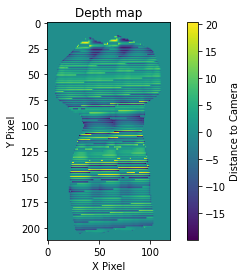

In [187]:
depth_visualization(z_r)

# Surface Reconstruction(舊版)

# save 3D ply

In [188]:
image_row = h
image_col = w
def save_ply(Z,filepath):
    Z_map = np.reshape(Z, (image_row,image_col)).copy()
    data = np.zeros((image_row*image_col,3),dtype=np.float32)
    # let all point float on a base plane 
    baseline_val = np.min(Z_map)
#     baseline_val = np.max(Z_map)
#     baseline_val = np.median(Z_map)
#     baseline_val = np.mean(Z_map)
    Z_map[np.where(Z_map == 0)] = baseline_val
    for i in range(image_row):
        for j in range(image_col):
            idx = i * image_col + j
            data[idx][0] = j
            data[idx][1] = i
            data[idx][2] = Z_map[image_row - 1 - i][j]
    # output to ply file
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(data)
    o3d.io.write_point_cloud(filepath, pcd,write_ascii=True)

In [189]:
save_ply(z_r, "./{}.ply".format(source))

In [190]:
show_ply("./{}.ply".format(source))